In [117]:
import csv
import os
import math
import numpy as np
from sklearn import manifold
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from matplotlib import pyplot
%matplotlib inline

In [4]:
NOISE_DIR = "/Users/siva/Documents/speaker_recognition/datasets/musan/csv_files/"
VOICE_DIR = "/Users/siva/Documents/speaker_recognition/datasets/musan/csv_files/"

In [5]:
os.chdir(NOISE_DIR)
noise_coefficients = []
voice_coefficients = []
noise_prefix = ["music","noise"]
voice_prefix = ["speech"]
for each_file in os.listdir():
    if each_file[3:8] in noise_prefix:
        with open(each_file) as noise_f:
            for each_row in csv.reader(noise_f):
                noise_coefficients.append(list(map(float,each_row)))
    if each_file[3:9] in voice_prefix:
        with open(each_file) as voice_f:
            for each_row in csv.reader(voice_f):
                voice_coefficients.append(list(map(float,each_row)))
noise_coefficients = np.array(noise_coefficients)
voice_coefficients = np.array(voice_coefficients)
print(len(noise_coefficients))
print(len(voice_coefficients))

89493
77766


In [6]:
test_noise = np.array(noise_coefficients[0:1000])
test_voice = np.array(voice_coefficients[0:1000])
test = np.vstack((test_noise,test_voice))
print(len(test_voice),len(test_voice),test.shape)

1000 1000 (2000, 13)


In [144]:
#noise_embedded = manifold.TSNE(n_components = 2).fit_transform(test)
Y = manifold.MDS(n_components = 3, max_iter=100, n_init=1).fit_transform(test)
#Y = manifold.SpectralEmbedding(n_components=2,n_neighbors=20).fit_transform(test)
#Y = manifold.TSNE(n_components = 2).fit_transform(test)
#Y = tsne(test, 2, 13, 30.0)

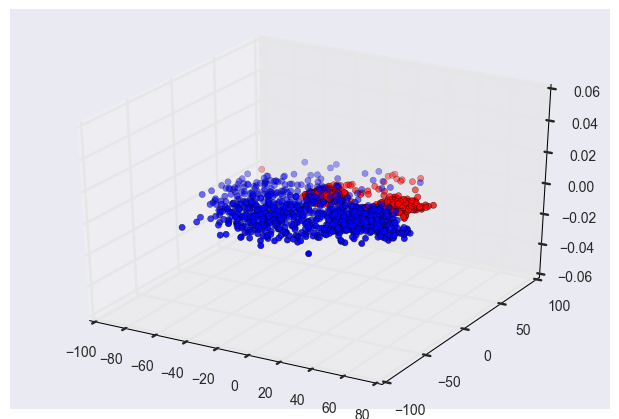

In [145]:
from mpl_toolkits.mplot3d import Axes3D
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(Y[0:1000,0],Y[0:1000,1],c = "r")
#plt.show()
ax.scatter(Y[1000:2000,0],Y[1000:2000,1],c = "b")

In [146]:
def noise_model(INPUT_DIM,HIDDEN_DIM,OUTPUT_DIM,LEARNING_RATE):
    x = tf.placeholder(tf.float32,[None,INPUT_DIM])
    y = tf.placeholder(tf.float32,[None,OUTPUT_DIM])
    z = tf.placeholder(tf.float32,[None,1])
    
    #initializer_ = tf.contrib.layers.xavier_initializer()
    initializer_ = tf.truncated_normal_initializer()
    
    w1 = tf.get_variable("w1",shape = [INPUT_DIM,HIDDEN_DIM],initializer = initializer_)
    w2 = tf.get_variable("w2",shape = [HIDDEN_DIM,OUTPUT_DIM],initializer = initializer_)
    
    b1 = tf.get_variable("b1",shape = [HIDDEN_DIM],initializer = initializer_)
    b2 = tf.get_variable("b2",shape = [OUTPUT_DIM],initializer = initializer_)
    
    w3 = tf.get_variable("w3",shape = [HIDDEN_DIM,1],initializer = initializer_)
    b3 = tf.get_variable("b3",shape = [1],initializer = initializer_)
    
    relu_1 = tf.nn.tanh(tf.matmul(x,w1) + b1)
    out_1 = tf.matmul(relu_1,w2) + b2
    out_2 = tf.matmul(relu_1,w3) + b3
    
    recreation_loss = tf.sqrt(tf.reduce_mean(tf.square(out_1 - y))) + (0.01*tf.nn.l2_loss(w1)) + (0.01*tf.nn.l2_loss(w2))
    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = z,logits = out_2)
    total_loss = (1*recreation_loss) + (3*classification_loss)
    #total_loss = classification_loss
    
    optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(total_loss)
    
    return {"inputs":[x,y,z],"output":[out_1,out_2],"loss":total_loss,"optimizer":optimizer,"relu_1":relu_1}

In [147]:
def load_data():
    noise_data = np.hstack((noise_coefficients,np.zeros_like(noise_coefficients[:,0:1])))
    voice_data = np.hstack((voice_coefficients,np.ones_like(voice_coefficients[:,0:1])))
    total_data = np.vstack((noise_data,voice_data))
    #random.shuffle(total_data)
    return total_data[:,0:-1],np.expand_dims(total_data[:,-1],axis = 1)

In [148]:
def noise_model_train(EPOCHS = 300,BATCH_SIZE = 500):
    tf.reset_default_graph()
    model = noise_model(13,13,13,0.001)
    train_data,train_labels = load_data()
    
    train_loss_list = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(EPOCHS):
            train_loss = []
            for b in range(int(train_data.shape[0]/BATCH_SIZE)):
                train_batch_d,train_labels_b = train_data[b*BATCH_SIZE:(b+1)*BATCH_SIZE,:],\
                                                train_labels[b*BATCH_SIZE:(b+1)*BATCH_SIZE,:]
                feed_dict_ = dict(zip(model["inputs"],[train_batch_d,train_batch_d,train_labels_b]))
                to_compute = [model["optimizer"],model["loss"]]
                _,loss_ = sess.run(to_compute,feed_dict = feed_dict_)
                train_loss.append(loss_)
                avg_train_loss = np.mean(train_loss)
            if e%10 == 0 and e!=0:
                print("epoch:",e,"loss:",avg_train_loss)
            train_loss_list.append(avg_train_loss)
            
        after_training_ = sess.run(model["relu_1"],feed_dict = dict(zip(model["inputs"],
                                                    [train_data[(89493-1000):(89493+1000),:],
                                                     train_data[(89493-1000):(89493+1000),:],
                                                     train_labels[(89493-1000):(89493+1000),:]])))
        
            
    plt.plot(np.arange(len(train_loss_list)),train_loss_list)
    return after_training_,train_labels[(89493-1000):(89493+1000),:]

In [ ]:
after_t,labels = noise_model_train()

epoch: 10 loss: 12.8794
epoch: 20 loss: 11.9584
epoch: 30 loss: 11.5483
epoch: 40 loss: 11.2998
epoch: 50 loss: 11.1141
epoch: 60 loss: 10.9674
epoch: 70 loss: 10.8746
epoch: 80 loss: 10.8166
epoch: 90 loss: 10.7811
epoch: 100 loss: 10.755
epoch: 110 loss: 10.7314
epoch: 120 loss: 10.7126
epoch: 130 loss: 10.699
epoch: 140 loss: 10.6887
epoch: 150 loss: 10.6812
epoch: 160 loss: 10.6742
epoch: 170 loss: 10.6675
epoch: 180 loss: 10.6612
epoch: 190 loss: 10.6562
epoch: 200 loss: 10.6509
epoch: 210 loss: 10.6455
epoch: 220 loss: 10.6413
epoch: 230 loss: 10.6376
epoch: 240 loss: 10.6341
epoch: 250 loss: 10.6312
epoch: 260 loss: 10.6293


In [137]:
#after_t_embedding =  manifold.SpectralEmbedding(n_components=2,n_neighbors=20).fit_transform(after_t)
#after_t_embedding = manifold.TSNE(n_components = 2).fit_transform(after_t)
after_t_embedding = manifold.MDS(n_components = 3, max_iter=100, n_init=1).fit_transform(after_t.astype(np.float64))
#after_t_embedding = after_t

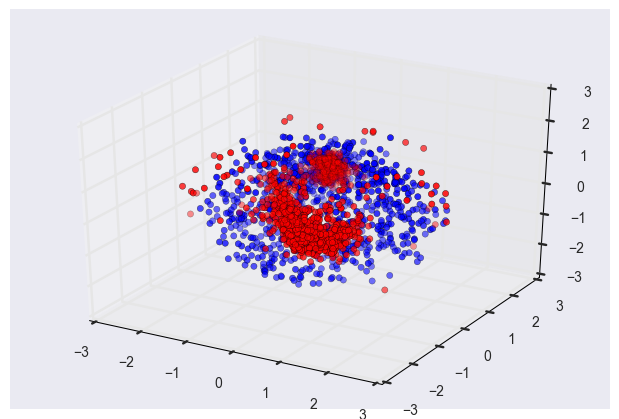

In [138]:
from mpl_toolkits.mplot3d import Axes3D
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(after_t_embedding[labels[:,0] == 1][:,0],after_t_embedding[labels[:,0] == 1][:,1],zs = after_t_embedding[labels[:,0] == 1][:,2],c = "b")
#plt.show()
ax.scatter(after_t_embedding[labels[:,0] == 0][:,0],after_t_embedding[labels[:,0] == 0][:,1],zs = after_t_embedding[labels[:,0] == 0][:,2],c = "r")